In [54]:
# Cell 1｜Imports + Paths + DuckDB connect

import duckdb
import numpy as np
import pandas as pd
from pathlib import Path

from scipy.stats import norm, chisquare
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt

DATA_DIR = Path("../data")
SALT = "checkout_ui_v1"
ASSIGN_PATH = DATA_DIR / f"assignment_{SALT}.parquet"

assert ASSIGN_PATH.exists(), f"Missing: {ASSIGN_PATH}"

con = duckdb.connect(database=":memory:")

con.execute(f"""
CREATE OR REPLACE VIEW assignment AS
SELECT *
FROM read_parquet('{ASSIGN_PATH.as_posix()}')
""")

# Quick sanity
con.execute("SELECT COUNT(*) AS n FROM assignment").df()


,n
0,5316128


In [55]:
# Cell 2｜Schema check + load REAL segments (Phase 3) + create base view

cols = con.execute("DESCRIBE assignment").df()
display(cols)

colset = set(cols["column_name"].tolist())

def col_exists(name): 
    return name in colset

# ---- Exposure / outcome (prefer boolean) ----
if col_exists("cart"):
    exposure_expr = "CAST(cart AS INTEGER) = 1"
elif col_exists("cart_time"):
    exposure_expr = "cart_time IS NOT NULL"
else:
    raise ValueError("No exposure column found. Need 'cart' or 'cart_time'.")

if col_exists("purchase"):
    outcome_expr = "CAST(purchase AS INTEGER) = 1"
elif col_exists("purchase_time"):
    outcome_expr = "purchase_time IS NOT NULL"
else:
    raise ValueError("No outcome column found. Need 'purchase' or 'purchase_time'.")

print("Using exposure expr:", exposure_expr)
print("Using outcome expr:", outcome_expr)

# ---- Load real segment table (Phase 3 output) ----
SEG_PATH = DATA_DIR / "user_segment.csv"

if SEG_PATH.exists():
    # Your CSV columns: user_id, first_seen_time, user_type
    con.execute(f"""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT
      CAST("user_id" AS BIGINT) AS user_id,
      CAST("user_type" AS VARCHAR) AS user_segment,
      "first_seen_time" AS first_seen_time
    FROM read_csv_auto('{SEG_PATH.as_posix()}', HEADER=TRUE)
    """)
    print("✅ Real segments loaded from:", SEG_PATH)

    # Optional: show distribution
    seg_counts = con.execute("""
    SELECT user_segment, COUNT(*) AS n
    FROM user_segment
    GROUP BY user_segment
    ORDER BY n DESC
    """).df()
    display(seg_counts)

else:
    # Keep pipeline stable if file missing
    con.execute("""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT CAST(NULL AS BIGINT) AS user_id,
           CAST(NULL AS VARCHAR) AS user_segment,
           CAST(NULL AS VARCHAR) AS first_seen_time
    WHERE FALSE
    """)
    print("⚠️ Missing user_segment.csv. Will default to 'Unknown'.")

# ---- Create base view with REAL segment attached ----
con.execute(f"""
CREATE OR REPLACE VIEW base AS
SELECT
  a.user_id,
  CAST(a.variant AS INTEGER) AS variant,
  ({exposure_expr}) AS exposed,
  ({outcome_expr}) AS purchase,
  COALESCE(s.user_segment, 'Unknown') AS segment_raw
FROM assignment a
LEFT JOIN user_segment s
ON a.user_id = s.user_id
""")

# ---- Sanity check: overall rates + segment coverage ----
overall = con.execute("""
SELECT 
  COUNT(*) AS n,
  AVG(CASE WHEN exposed THEN 1 ELSE 0 END) AS exposed_rate,
  AVG(CASE WHEN purchase THEN 1 ELSE 0 END) AS purchase_rate,
  AVG(CASE WHEN segment_raw <> 'Unknown' THEN 1 ELSE 0 END) AS segment_coverage
FROM base
""").df()

display(overall)

segment_check = con.execute("""
SELECT segment_raw, COUNT(*) AS n
FROM base
GROUP BY segment_raw
ORDER BY n DESC
LIMIT 20
""").df()

display(segment_check)


,column_name,column_type,null,key,default,extra
0,user_id,BIGINT,YES,None,None,None
1,variant,INTEGER,YES,None,None,None
2,view,BOOLEAN,YES,None,None,None
3,cart,BOOLEAN,YES,None,None,None
4,purchase,BOOLEAN,YES,None,None,None


Using exposure expr: CAST(cart AS INTEGER) = 1
Using outcome expr: CAST(purchase AS INTEGER) = 1
✅ Real segments loaded from: ..\data\user_segment.csv


,user_segment,n
0,returning,4877171
1,new,439478


,n,exposed_rate,purchase_rate,segment_coverage
0,5316128,0.198001,0.101412,1.0


,segment_raw,n
0,returning,4876696
1,new,439432


In [56]:
# Cell 3｜Define treatment eligibility + parameters (Exposure-aware uplift)

# Treatment eligibility: in variant=1 AND exposed
con.execute("""
CREATE OR REPLACE VIEW base_flags AS
SELECT
  *,
  (variant = 1) AS in_treatment_group,
  (variant = 1 AND exposed) AS treated_exposed
FROM base
""")

# Uplift parameters (relative lift on purchase probability within exposed)
UPLIFT_REL = 0.05  # 5% relative lift within exposed (adjust: 0.02 ~ 0.07)
SEED = 42

UPLIFT_REL, SEED


(0.05, 42)

In [57]:
# Cell 4｜Simulate purchase under treatment × exposure (Bernoulli re-draw, stable & vectorized)

# We simulate counterfactual outcome:
# - Control group: purchase_sim = purchase (no change)
# - Treatment & exposed: increase purchase probability by relative lift
#   p1 = min(1, p0 * (1 + UPLIFT_REL))
#
# Implementation approach:
# 1) Compute baseline purchase rate among exposed in control group (variant=0 & exposed)
# 2) For each treated_exposed user, resample purchase_sim ~ Bernoulli(p1)
#    while for everyone else, purchase_sim = purchase
#
# This makes the simulated effect align with the baseline mechanism.

np.random.seed(SEED)

baseline = con.execute("""
SELECT
  AVG(CASE WHEN purchase THEN 1 ELSE 0 END) AS p0_exposed_control
FROM base_flags
WHERE variant = 0 AND exposed
""").df()

p0 = float(baseline.loc[0, "p0_exposed_control"])
p1 = min(1.0, p0 * (1.0 + UPLIFT_REL))

p0, p1


(0.5112412613275575, 0.5368033243939354)

In [58]:
# Cell 5｜Materialize simulation results into DuckDB (purchase_sim)

# We'll pull only the minimal columns into pandas for simulation flags,
# then push back a simulated column. This is light: user-level table (~5.3M rows).
# If you want fully in DuckDB, it's possible but cumbersome for RNG.

df = con.execute("""
SELECT user_id, variant, exposed, purchase, treated_exposed, segment_raw
FROM base_flags
""").df()

# Initialize simulated as original
df["purchase_sim"] = df["purchase"].astype(bool)

# Apply treatment only to exposed users in treatment group:
mask = df["treated_exposed"].astype(bool)

# Resample outcomes for treated_exposed users using p1
# (We overwrite purchase_sim for this subset to match the counterfactual distribution.)
df.loc[mask, "purchase_sim"] = (np.random.rand(mask.sum()) < p1)

# Push back to DuckDB as a view
con.register("sim_df", df[["user_id", "variant", "exposed", "purchase", "purchase_sim", "segment_raw"]])

con.execute("""
CREATE OR REPLACE VIEW sim AS
SELECT * FROM sim_df
""")

con.execute("""
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS sim_purchase_rate
FROM sim
""").df()


,n,sim_purchase_rate
0,5316128,0.103705


In [59]:
# Cell 6｜Estimate ITT (Global Impact): all users denominator + CI

# ITT = p_hat(treat, all) - p_hat(control, all)
itt_tbl = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_users,
  SUM(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS purchasers,
  SUM(CASE WHEN exposed THEN 1 ELSE 0 END) AS exposed_users
FROM sim
GROUP BY variant
ORDER BY variant
""").df()

display(itt_tbl)

# Compute ITT + Wald CI
p0_all = itt_tbl.loc[itt_tbl["variant"] == 0, "purchasers"].values[0] / itt_tbl.loc[itt_tbl["variant"] == 0, "n_users"].values[0]
p1_all = itt_tbl.loc[itt_tbl["variant"] == 1, "purchasers"].values[0] / itt_tbl.loc[itt_tbl["variant"] == 1, "n_users"].values[0]

n0_all = itt_tbl.loc[itt_tbl["variant"] == 0, "n_users"].values[0]
n1_all = itt_tbl.loc[itt_tbl["variant"] == 1, "n_users"].values[0]

itt = p1_all - p0_all
se_itt = np.sqrt(p0_all * (1 - p0_all) / n0_all + p1_all * (1 - p1_all) / n1_all)
ci_itt = (itt - 1.96 * se_itt, itt + 1.96 * se_itt)

# z-test (optional)
z_itt, p_itt = proportions_ztest(
    count=np.array([
        itt_tbl.loc[itt_tbl["variant"] == 1, "purchasers"].values[0],
        itt_tbl.loc[itt_tbl["variant"] == 0, "purchasers"].values[0],
    ]),
    nobs=np.array([n1_all, n0_all])
)

summary_itt = pd.DataFrame([{
    "metric": "ITT (Global, all users)",
    "p_treat": p1_all,
    "p_control": p0_all,
    "diff": itt,
    "ci_low": ci_itt[0],
    "ci_high": ci_itt[1],
    "z": z_itt,
    "p_value": p_itt
}])

summary_itt


,variant,n_users,purchasers,exposed_users
0,0,2659017,269554.0,527254.0
1,1,2657111,281754.0,525343.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"ITT (Global, all users)",0.106038,0.101374,0.004664,0.004146,0.005182,17.636691,1.287842e-69


In [60]:
# Cell 7｜Estimate CATE on Exposed (Local Impact): exposed users only + CI

cate_tbl = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_exposed,
  SUM(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS purchasers_exposed
FROM sim
WHERE exposed
GROUP BY variant
ORDER BY variant
""").df()

display(cate_tbl)

p0_exp = cate_tbl.loc[cate_tbl["variant"] == 0, "purchasers_exposed"].values[0] / cate_tbl.loc[cate_tbl["variant"] == 0, "n_exposed"].values[0]
p1_exp = cate_tbl.loc[cate_tbl["variant"] == 1, "purchasers_exposed"].values[0] / cate_tbl.loc[cate_tbl["variant"] == 1, "n_exposed"].values[0]

n0_exp = cate_tbl.loc[cate_tbl["variant"] == 0, "n_exposed"].values[0]
n1_exp = cate_tbl.loc[cate_tbl["variant"] == 1, "n_exposed"].values[0]

cate = p1_exp - p0_exp
se_cate = np.sqrt(p0_exp * (1 - p0_exp) / n0_exp + p1_exp * (1 - p1_exp) / n1_exp)
ci_cate = (cate - 1.96 * se_cate, cate + 1.96 * se_cate)

z_cate, p_cate = proportions_ztest(
    count=np.array([
        cate_tbl.loc[cate_tbl["variant"] == 1, "purchasers_exposed"].values[0],
        cate_tbl.loc[cate_tbl["variant"] == 0, "purchasers_exposed"].values[0],
    ]),
    nobs=np.array([n1_exp, n0_exp])
)

summary_cate = pd.DataFrame([{
    "metric": "CATE (Local, exposed only)",
    "p_treat": p1_exp,
    "p_control": p0_exp,
    "diff": cate,
    "ci_low": ci_cate[0],
    "ci_high": ci_cate[1],
    "z": z_cate,
    "p_value": p_cate
}])

summary_cate


,variant,n_exposed,purchasers_exposed
0,0,527254,269554.0
1,1,525343,281754.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"CATE (Local, exposed only)",0.536324,0.511241,0.025083,0.023175,0.02699,25.76287,2.312777e-146


In [61]:
# Cell 8｜6.5 Placebo / Sanity Check: non-exposed should show ~0 effect

placebo_tbl = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_non_exposed,
  SUM(CASE WHEN purchase_sim THEN 1 ELSE 0 END) AS purchasers_non_exposed
FROM sim
WHERE NOT exposed
GROUP BY variant
ORDER BY variant
""").df()

display(placebo_tbl)

p0_ne = placebo_tbl.loc[placebo_tbl["variant"] == 0, "purchasers_non_exposed"].values[0] / placebo_tbl.loc[placebo_tbl["variant"] == 0, "n_non_exposed"].values[0]
p1_ne = placebo_tbl.loc[placebo_tbl["variant"] == 1, "purchasers_non_exposed"].values[0] / placebo_tbl.loc[placebo_tbl["variant"] == 1, "n_non_exposed"].values[0]

n0_ne = placebo_tbl.loc[placebo_tbl["variant"] == 0, "n_non_exposed"].values[0]
n1_ne = placebo_tbl.loc[placebo_tbl["variant"] == 1, "n_non_exposed"].values[0]

diff_ne = p1_ne - p0_ne
se_ne = np.sqrt(p0_ne * (1 - p0_ne) / n0_ne + p1_ne * (1 - p1_ne) / n1_ne)
ci_ne = (diff_ne - 1.96 * se_ne, diff_ne + 1.96 * se_ne)

z_ne, p_ne = proportions_ztest(
    count=np.array([
        placebo_tbl.loc[placebo_tbl["variant"] == 1, "purchasers_non_exposed"].values[0],
        placebo_tbl.loc[placebo_tbl["variant"] == 0, "purchasers_non_exposed"].values[0],
    ]),
    nobs=np.array([n1_ne, n0_ne])
)

summary_placebo = pd.DataFrame([{
    "metric": "Placebo (Non-exposed)",
    "p_treat": p1_ne,
    "p_control": p0_ne,
    "diff": diff_ne,
    "ci_low": ci_ne[0],
    "ci_high": ci_ne[1],
    "z": z_ne,
    "p_value": p_ne
}])

summary_placebo


,variant,n_non_exposed,purchasers_non_exposed
0,0,2131763,0.0
1,1,2131768,0.0


d:\software\anaconda\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,Placebo (Non-exposed),0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [62]:
# Cell 9｜6.6 Heterogeneity within exposed: New vs Returning (production-grade)

df2 = df.copy()

# --- 0) Hard requirement: segment_raw must exist (otherwise upstream join/column retention failed)
if "segment_raw" not in df2.columns:
    raise ValueError("segment_raw column missing — upstream join or column retention failed. "
                     "Fix Cell 5 SELECT to include segment_raw and register it back to DuckDB if needed.")

# --- 1) Normalize raw segment values
raw = df2["segment_raw"]

# Treat blanks as missing
raw_str = raw.astype("string").str.strip()
raw_str = raw_str.replace({"": pd.NA})

# Define unknown tokens
UNKNOWN_TOKENS = {
    "unknown", "na", "n/a", "nan", "none", "null", "<na>", "missing", "undefined"
}

# Determine whether we have any real segment information
# "real" = not missing AND not in unknown tokens
raw_lc = raw_str.str.lower()
is_missing = raw_str.isna()
is_unknown = raw_lc.isin(list(UNKNOWN_TOKENS))
has_real_segment = (~is_missing & ~is_unknown).any()

# Quick audit (prints once, helps you debug instantly)
total_n = len(df2)
known_n = int((~is_missing & ~is_unknown).sum())
print(f"[Segment Audit] total={total_n:,} | real_segment_rows={known_n:,} | coverage={known_n/total_n:.2%}")

# --- 2) If no real segments, fall back to DEMO only
if not has_real_segment:
    print("WARNING: No real segment values found. Using deterministic proxy segment (DEMO).")
    df2["segment"] = np.where((df2["user_id"].astype("int64") % 2) == 0, "New", "Returning")

else:
    # --- 3) Map REAL segments into {New, Returning, Unknown, Other}
    s = raw_str.fillna("Unknown")

    # 3.1 Try numeric/boolean encoding first
    # Accept: 0/1, True/False, "0"/"1", "true"/"false"
    s_lc = s.astype("string").str.strip().str.lower()

    bool_map = {
        "true": 1, "false": 0,
        "1": 1, "0": 0,
        "yes": 1, "no": 0
    }

    # If (after mapping) every non-missing value is in {0,1}, treat as boolean encoding
    mapped = s_lc.map(bool_map)
    # also allow native numeric 0/1
    numeric = pd.to_numeric(s_lc, errors="coerce")
    numeric01 = numeric.where(numeric.isin([0, 1]))

    # Decide if boolean-ish: if most non-missing can be interpreted as 0/1 and nothing outside {0,1}
    non_missing = ~s_lc.isna()
    interpreted = (~mapped.isna()) | (~numeric01.isna()) | (s_lc.isin(list(UNKNOWN_TOKENS))) | (s_lc.eq("unknown"))
    # If all non-missing values are interpretable, we consider it boolean-ish
    is_booleanish = interpreted[non_missing].all()

    if is_booleanish:
        val01 = numeric01.fillna(mapped).fillna(0).astype(int)
        # Convention: 1 => New, 0 => Returning (adjust here if your encoding is opposite)
        df2["segment"] = np.where(val01 == 1, "New", "Returning")
        # Preserve true unknowns (optional): if you want Unknown to remain Unknown instead of Returning
        # uncomment the next line:
        df2.loc[s_lc.isin(list(UNKNOWN_TOKENS)) | s_lc.eq("unknown"), "segment"] = "Unknown"
    else:
        # 3.2 String normalization for common business labels (NA-safe)
        ss = s.astype("string").str.strip().str.lower()

        c_unknown = (ss.isin(list(UNKNOWN_TOKENS)) | ss.eq("unknown")).fillna(False).to_numpy(dtype=bool)
        c_new = (ss.str.contains("new", na=False) | ss.str.contains("first", na=False)).to_numpy(dtype=bool)
        c_ret = (
            ss.str.contains("return", na=False)
            | ss.str.contains("exist", na=False)
            | ss.str.contains("old", na=False)
            | ss.str.contains("repeat", na=False)
        ).to_numpy(dtype=bool)

        df2["segment"] = np.select(
            [c_unknown, c_new, c_ret],
            ["Unknown", "New", "Returning"],
            default="Other"
        )

# --- 4) Keep only exposed users for heterogeneity
hexp = df2[df2["exposed"]].copy()

# --- 5) Group stats by (segment, variant)
het = (hexp
       .groupby(["segment", "variant"], dropna=False)
       .agg(
           n_users=("user_id", "size"),
           purchasers=("purchase_sim", "sum")
       )
       .reset_index())

het["purchase_rate"] = het["purchasers"] / het["n_users"]

# --- 6) Print distribution after mapping (helps ensure you're not accidentally getting all "Other")
print("[Segment Distribution in Exposed]")
display(het.groupby("segment")["n_users"].sum().sort_values(ascending=False).to_frame("n_exposed_users"))

het



[Segment Audit] total=5,316,128 | real_segment_rows=5,316,128 | coverage=100.00%
[Segment Distribution in Exposed]


,n_exposed_users
segment,
Returning,1001021
New,51576


,segment,variant,n_users,purchasers,purchase_rate
0,New,0,25860,12448,0.481361
1,New,1,25716,13840,0.538186
2,Returning,0,501394,257106,0.512782
3,Returning,1,499627,267914,0.536228


,segment,diff,ci_low,ci_high,p0,p1,n0,n1
0,New,0.056825,0.04821,0.065440,0.481361,0.538186,25860.0,25716.0
1,Returning,0.023446,0.02149,0.025402,0.512782,0.536228,501394.0,499627.0


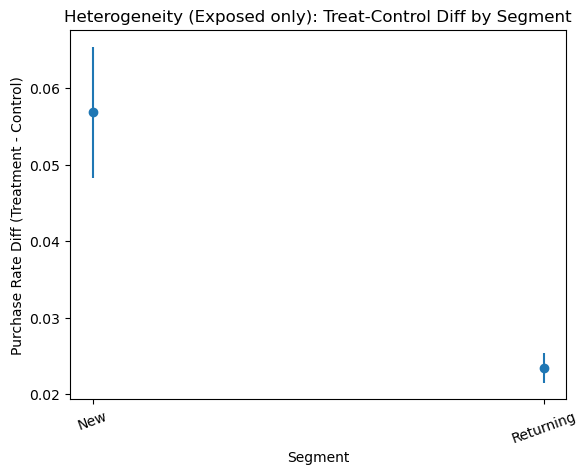

In [63]:
# Cell 10｜Heterogeneity: effect (treat-control) within each segment + CI + plot

def diff_ci_for_segment(seg_df):
    # expects two rows: variant 0 and 1
    d0 = seg_df[seg_df["variant"]==0].iloc[0]
    d1 = seg_df[seg_df["variant"]==1].iloc[0]
    p0 = d0["purchase_rate"]; p1 = d1["purchase_rate"]
    n0 = d0["n_users"]; n1 = d1["n_users"]
    diff = p1 - p0
    se = np.sqrt(p0*(1-p0)/n0 + p1*(1-p1)/n1)
    ci = (diff - 1.96*se, diff + 1.96*se)
    return pd.Series({"diff": diff, "ci_low": ci[0], "ci_high": ci[1], "p0": p0, "p1": p1, "n0": n0, "n1": n1})

het_effect = (het.groupby("segment")
              .apply(diff_ci_for_segment)
              .reset_index())

display(het_effect)

# Plot diffs with CI (simple error bars)
plt.figure()
plt.errorbar(
    x=het_effect["segment"].astype(str),
    y=het_effect["diff"],
    yerr=[het_effect["diff"] - het_effect["ci_low"], het_effect["ci_high"] - het_effect["diff"]],
    fmt="o"
)
plt.title("Heterogeneity (Exposed only): Treat-Control Diff by Segment")
plt.xlabel("Segment")
plt.ylabel("Purchase Rate Diff (Treatment - Control)")
plt.xticks(rotation=20)
plt.show()


In [64]:
# Cell 11｜One-page summary table (ITT + CATE + Placebo) for README screenshot

summary = pd.concat([summary_itt, summary_cate, summary_placebo], ignore_index=True)

# Format helper (optional)
summary_fmt = summary.copy()
for c in ["p_treat","p_control","diff","ci_low","ci_high"]:
    summary_fmt[c] = summary_fmt[c].astype(float)

summary_fmt


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"ITT (Global, all users)",0.106038,0.101374,0.004664,0.004146,0.005182,17.636691,1.287842e-69
1,"CATE (Local, exposed only)",0.536324,0.511241,0.025083,0.023175,0.026990,25.762870,2.312777e-146
2,Placebo (Non-exposed),0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
